In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define 2D probability density function p(x)
def p(x):
    """
    Example: Mixture of two Gaussian distributions.
    """
    mean1 = np.array([0.0, 0.0])
    mean2 = np.array([2.0, 2.0])
    cov = np.eye(2) * 0.5  # Shared covariance
    gaussian1 = np.exp(-0.5 * np.sum((x - mean1) @ np.linalg.inv(cov) * (x - mean1), axis=1))
    gaussian2 = np.exp(-0.5 * np.sum((x - mean2) @ np.linalg.inv(cov) * (x - mean2), axis=1))
    return gaussian1 + gaussian2

In [3]:
# Adaptive sampling
def adaptive_sampling(grid_size, refinement_threshold=0.85, max_iterations=10):
    """
    Refines the grid adaptively based on the density function p(x).
    """
    x = np.linspace(-3, 5, grid_size)
    y = np.linspace(-3, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)
    for _ in range(max_iterations):
        # Evaluate p(x) on current points
        p_values = p(points)
        high_density = points[p_values > refinement_threshold*max(p_values)]

        # Subdivide regions with high density
        subdivided = []
        for point in high_density:
            step = (x[1] - x[0])/2  # Half the step size
            new_points = [point + np.array([dx, dy]) * step 
                            for dx in [-0.5, 0.5] for dy in [-0.5, 0.5]]
            subdivided.extend(new_points)
        
        # Add new points and ensure uniqueness
        points = np.vstack([points, subdivided])
        points = np.unique(points, axis=0)
    
    return points


In [4]:
# Generate adaptive samples
grid_size = 5
refinement_threshold = 0.5 
max_iterations = 25
samples = adaptive_sampling(grid_size, refinement_threshold, max_iterations)

In [5]:
print(grid_size**2, samples.shape)

25 (63, 2)


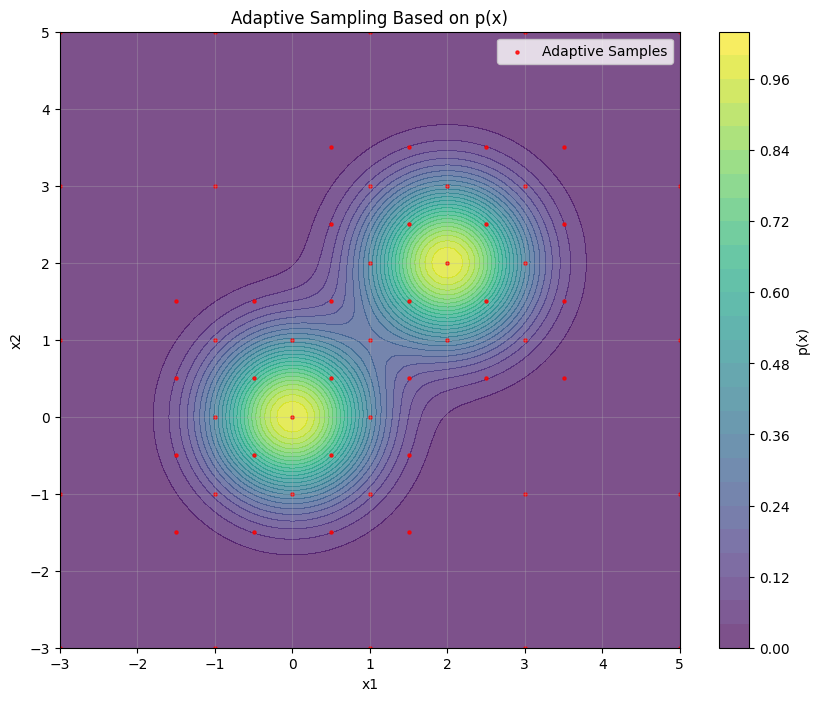

In [6]:
# Plotting
plt.figure(figsize=(10, 8))

# Contour plot of p(x)
x = np.linspace(-3, 5, 100)
y = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
p_values = p(grid_points)
plt.contourf(X, Y, p_values.reshape(100, 100), levels=30, cmap="viridis", alpha=0.7)
plt.colorbar(label="p(x)")

# Plot adaptive samples
plt.scatter(samples[:, 0], samples[:, 1], s=5, c="red", alpha=0.8, label="Adaptive Samples")

plt.title("Adaptive Sampling Based on p(x)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

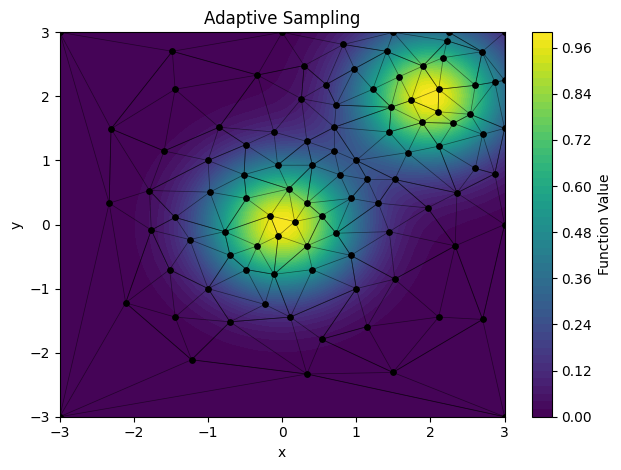

In [19]:
import adaptive
from scipy.spatial import Delaunay

# Define a custom 2D function
def p(xy):
    """
    Example: Mixture of two Gaussian distributions.
    """
    mean1 = np.array([0.0, 0.0])
    mean2 = np.array([2.0, 2.0])
    cov = np.eye(2) * 0.5  # Shared covariance
    x,y = xy 
    x_ = np.array([x, y]).reshape(1,-1)
    gaussian1 = np.exp(-0.5 * np.sum((x_ - mean1) @ np.linalg.inv(cov) * (x_ - mean1), axis=1))
    gaussian2 = np.exp(-0.5 * np.sum((x_ - mean2) @ np.linalg.inv(cov) * (x_ - mean2), axis=1))

    return gaussian1 + gaussian2

# Define the sampling bounds
bounds = [(-3, 3), (-3, 3)]

# Create an adaptive learner
learner = adaptive.Learner2D(p, bounds)

# Run the learner to adaptively sample the function
adaptive.runner.simple(learner, goal=lambda l: l.npoints > 100)

# Retrieve the data
data = learner.data
x, y = zip(*data.keys())

# Create a mesh grid for visualization
xx, yy = np.meshgrid(
    np.linspace(bounds[0][0], bounds[0][1], 50),
    np.linspace(bounds[1][0], bounds[1][1], 50),
)
zz = np.array([p((x, y)) for x, y in zip(xx.ravel(), yy.ravel())]).reshape(xx.shape)

# Delaunay triangulation of sampled points
tri = Delaunay(np.column_stack((x, y)))

fig, ax = plt.subplots()

# Plot contour
contour = plt.contourf(xx, yy, zz, levels=50, cmap="viridis")
plt.colorbar(contour, label="Function Value")

# Plot scatter points
plt.scatter(x, y, s=15, color="k")

# Plot Delaunay triangulation
for simplex in tri.simplices:
    pts = tri.points[simplex]
    plt.plot(pts[:, 0], pts[:, 1], 'k-', lw=0.5, alpha=0.5)

# Titles and labels
plt.title("Adaptive Sampling")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

